<h1>Rebalancing bot</h1>
<p>A rebalancing bot on Binance is an automated trading tool designed to maintain a specific asset allocation in a portfolio. It works by periodically adjusting the proportions of various cryptocurrencies to match a target distribution. For instance, if a portfolio is set to hold 50% Bitcoin and 50% Ethereum, and price fluctuations cause these ratios to shift, the bot automatically buys or sells assets to restore balance. This strategy helps maintain risk levels and capitalize on market movements, enabling passive portfolio management while minimizing the need for constant manual adjustments.</p>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.trend import EMAIndicator
from time import sleep
plt.rc('figure',titleweight='bold',titlesize='large',figsize=(15,9))
plt.rc('axes',labelweight='bold',labelsize='large',titleweight='bold',titlesize='large',grid=True)
plt.rc('grid',color='red',alpha=0.5)

<h3>The 'rebalancing_bot' class:</h3>
<ol>
    <li>
        <h3>The '__init__' function :</h3>
        Initialize a few important parameters.
        <ul>
            <li>'self.symbol' : What pair should be used for backtesting.</li>
            <li>'self.balance' : Initial balance of user. </li>
            <li>'self.start_date', 'self.end_date' : Denote the start and end date of the stategy.</li>
            <li>'self.allocation' : Shows the proportion of coins in the entire portfolio.</li>
            <li>'self.threshold' : Set the density deviation level when reached, rebalancing will begin.</li>
            <li>'self.profit' : Used to draw the profit curve.</li>
            <li>'self.orders' : For storing all placed order through period.</li>
            <li>'self.fee' : denote the total fee of the whole testing periods.</li>
            <li>'self.coin' ,'self.cash' : To determine amount of coin/cash we are holding.</li>
            <li>'self.portfolio' : Show total assert we have.</li>
        </ul>
    </li>
    <li>
        <h3>The 'get_portfolio' function :</h3>
        Return current total assert we have now ('self.coin' * 'price' + 'self.cash').
    </li>
    <li>
        <h3>The 'get_allocation' function :</h3>
        Get the curren allocation of our portfolio.
    </li>
    <li>
        <h3>The 'trade' function :</h3>
        Rebalance the portfolio when it exceeds the allowable level.
        <ul>
            <li>Loop through each candle of the dataframe and check current allocation.</li>
            <li>If the amount of cash exceeds the allowed level, sell a portion of coins to maintain the original ratio; conversely, if the amount of cash dominates, buy coins to rebalance.</li>
            <li>Updates the portfolio value after each candle.</li>
        </ul>
    </li>
    <li>
        <h3>The 'draw' function :</h3>
        Give an overview of what happened later while the strategy was executing.It will display a figure contain 2 subplots: the price plot and the profit plot.
        <ul>
            <li>The price chart displays the price during and at the time the order was placed.</li>
            <li>The profit plot show the cumulative profit during the time and total paid fee on the upper left corner.</li>
            <i>*Because this strategy has the characteristics of an arbitrage strategy such as spot grid (continuous buying and selling) and long-term investment (always maintaining a certain amount of coins in the portfolio), we will calculate the profit Profit based on initial capital spent (traded profit + holding profit).</i>
    </li>
</ol>

In [14]:
class rebalancing_bot():
    def __init__(self,symbol,balance,start_date=None,end_date=None,allocation=0.5,threshold=0.01):
        self.symbol=symbol
        self.balance=balance

        self.df = pd.read_csv(f'Data/{symbol}/{symbol}_15m.csv',index_col=0,parse_dates=True).loc[start_date:end_date]
        self.start_date=(start_date,self.df.index[0])[start_date==None]
        self.end_date=(end_date,self.df.index[-1])[end_date==None]
        self.price=self.df['Close']

        self.allocation=allocation
        self.threshold=threshold

        self.profit=[]
        self.order=[]
        self.fee=0
        self.coin=0
        self.cash=balance
        self.portfolio=None
    
    def get_portfolio(self, price):
        return self.coin * price + self.cash
    
    def get_allocation(self,price):
        self.portfolio = self.get_portfolio(price)
        coin_value = self.coin * price
        return coin_value / self.portfolio
    
    def trade(self):
        for i in range(self.df.shape[0]):
            price = self.df['Close'].iloc[i]
            current_allocation = self.get_allocation(price)

            if abs(current_allocation - self.allocation) > self.threshold:
                total_value=self.get_portfolio(price)
                target_coin_value = total_value *self.allocation
                current_coin_value = self.coin * price

                if current_coin_value < target_coin_value:
                    self.fee+=(target_coin_value-current_coin_value)*0.001
                    buy=(target_coin_value-current_coin_value)*0.999/price
                    self.cash-=buy*price
                    self.coin+=buy
                    self.order.append([self.df.index[i],price,1])
                    print(f'{self.df.index[i]} buy :{buy} {self.symbol} at {price}')
                else:
                    self.fee+=(current_coin_value-target_coin_value)*0.001
                    sell = (current_coin_value - target_coin_value)*0.999/price
                    self.cash += sell * price
                    self.coin -= sell
                    self.order.append([self.df.index[i],price,-1])
                    print(f'{self.df.index[i]} sell :{sell} {self.symbol} at {price}')
                
            self.profit.append(self.get_portfolio(price)-self.balance)
            self.portfolio = self.get_portfolio(price)
        self.df['Profit']=self.profit
    
    def draw(self):
        fg=plt.figure()
        ax1=fg.add_subplot(2,1,1)
        ax2=fg.add_subplot(2,1,2)

        self.df['Close'].plot(ax=ax1,color='black')
        ax1.set_title(f'{self.symbol} {self.start_date}-{self.end_date}')

        for index,price,pos in self.order:
            ax1.text(index,price,('S','B')[pos==1],color=('red','green')[pos==1])
        
        self.df['Profit'].plot(ax=ax2)
        ax2.set_title('Profit over Time')
        ax2.text(self.df.index[0],np.max(self.df['Profit'])*0.95,f'Total fee:-{round(self.fee,2)}',color='red')
        plt.tight_layout()
        plt.show()


In [15]:
symbol='BTCUSDT'
balance=1000
allocation=0.5
threshold=0.01
start_date='2023-01-01 00:00:00'
end_date='2024-01-01 00:00:00' 
#start_date,end_date=None,None

In [16]:
rebalancing=rebalancing_bot(symbol=symbol,balance=balance,start_date=start_date,end_date=end_date,allocation=allocation,threshold=threshold)

In [17]:
rebalancing.trade()

2023-01-01 00:00:00 buy :0.030119410346967163 BTCUSDT at 16583.99
2023-01-09 23:00:00 sell :0.000595688770720705 BTCUSDT at 17302.27
2023-01-12 07:45:00 sell :0.0007771808591294202 BTCUSDT at 18264.1
2023-01-13 03:45:00 sell :0.0005923567907209085 BTCUSDT at 19048.95
2023-01-14 05:00:00 sell :0.0006036273517010173 BTCUSDT at 19902.42
2023-01-14 07:30:00 sell :0.0007348943068161398 BTCUSDT at 21024.29
2023-01-21 03:30:00 sell :0.0006555156527546599 BTCUSDT at 22104.94
2023-01-21 16:45:00 sell :0.0005295765586779366 BTCUSDT at 23037.49
2023-02-02 07:30:00 sell :0.0006015032386779312 BTCUSDT at 24172.23
2023-02-05 19:45:00 buy :0.0005398383799254925 BTCUSDT at 23170.56
2023-02-10 02:15:00 buy :0.0005707728876744818 BTCUSDT at 22180.29
2023-02-16 02:00:00 sell :0.0005571754484403706 BTCUSDT at 23170.0
2023-02-16 03:45:00 sell :0.000516562385442721 BTCUSDT at 24145.04
2023-02-19 23:00:00 sell :0.0005045318219911229 BTCUSDT at 25157.82
2023-02-20 08:00:00 buy :0.0006683799950537951 BTCUSDT a

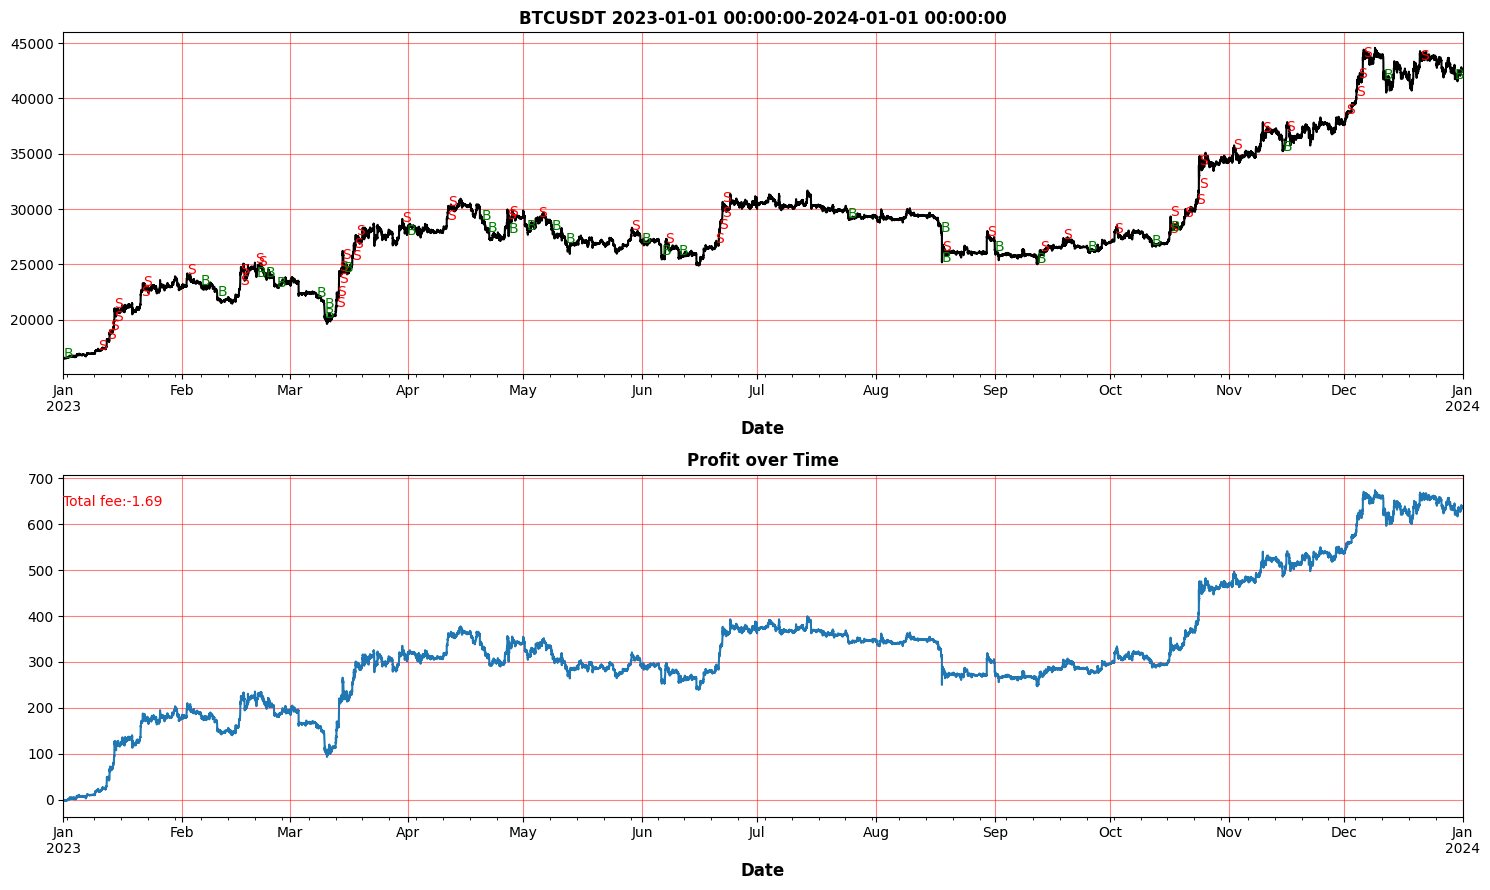

In [18]:
rebalancing.draw()